In [1]:
import torch
import torchvision
from PIL import Image
from torchvision.utils import draw_bounding_boxes
from torchvision.io import read_image
import matplotlib.pyplot as plt

%matplotlib inline

tensor([[ 30,  45, 330, 450],
        [320, 150, 690, 460]], dtype=torch.int32)


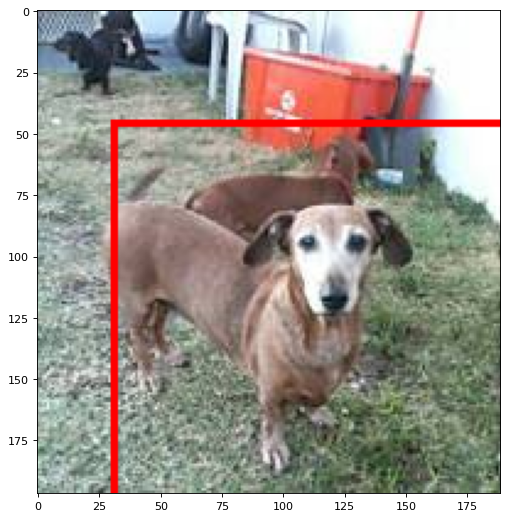

In [2]:
img = read_image('./images/57.jpg')

bbox1 = [30, 45, 330, 450]
bbox2 = [320, 150, 690, 460]
bbox = [bbox1, bbox2]
bbox = torch.tensor(bbox, dtype=torch.int)
print(bbox)

img_with_boxes = draw_bounding_boxes(img, bbox, width=3, colors=[(255,0,0),(0,255,0)])
img_with_boxes = torchvision.transforms.ToPILImage()(img_with_boxes)
plt.figure(figsize=(12, 8), dpi=80)
plt.imshow(img_with_boxes)

In [3]:
from torchvision import transforms as T

def img_to_model(path: str):
    transform = T.Compose([            
 
    T.Resize(256),                    
    T.CenterCrop(224),                
    T.ToTensor(),                     
    T.Normalize(                      
    mean=[0.485, 0.456, 0.406],                
    std=[0.229, 0.224, 0.225]                  
  
    )])

    img = Image.open(path)
    batch_t = torch.unsqueeze(transform(img), 0)

    return batch_t

/tmp/ipykernel_14329/124916070.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes = torch.tensor(output[0]['boxes'][0], dtype=torch.int).unsqueeze(0)


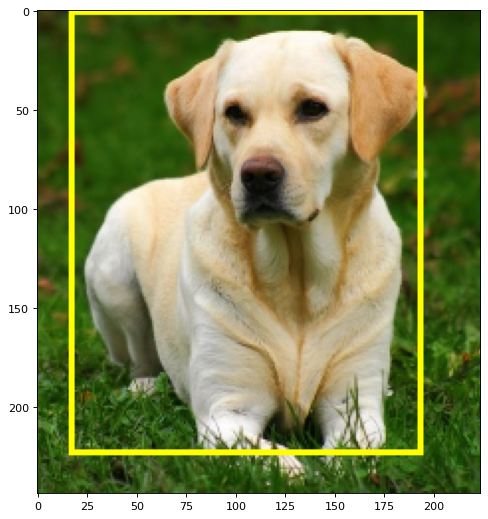

In [4]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True).eval()

img_model = img_to_model('./images/labrador.jpg')
img = read_image('./images/labrador.jpg')

transform_img = T.Compose([
    T.Resize(224)
])

output = model(img_model)
boxes = torch.tensor(output[0]['boxes'][0], dtype=torch.int).unsqueeze(0)

img_with_boxes = draw_bounding_boxes(transform_img(img), boxes, colors='yellow', width=3)
img_with_boxes = torchvision.transforms.ToPILImage()(img_with_boxes)
plt.figure(figsize=(12, 8), dpi=80)
plt.imshow(img_with_boxes)


In [9]:
import numpy as np

# Define the helper function
def decode_segmap(image, nc=21):
  label_colors = np.array([(0, 0, 0),  # 0=background
               # 1=aeroplane, 2=bicycle, 3=bird, 4=boat, 5=bottle
               (128, 0, 0), (0, 128, 0), (128, 128, 0), (0, 0, 128), (128, 0, 128),
               # 6=bus, 7=car, 8=cat, 9=chair, 10=cow
               (0, 128, 128), (128, 128, 128), (64, 0, 0), (192, 0, 0), (64, 128, 0),
               # 11=dining table, 12=dog, 13=horse, 14=motorbike, 15=person
               (192, 128, 0), (64, 0, 128), (192, 0, 128), (64, 128, 128), (192, 128, 128),
               # 16=potted plant, 17=sheep, 18=sofa, 19=train, 20=tv/monitor
               (0, 64, 0), (128, 64, 0), (0, 192, 0), (128, 192, 0), (0, 64, 128)])
  r = np.zeros_like(image).astype(np.uint8)
  g = np.zeros_like(image).astype(np.uint8)
  b = np.zeros_like(image).astype(np.uint8)
  for l in range(0, nc):
    idx = image == l
    r[idx] = label_colors[l, 0]
    g[idx] = label_colors[l, 1]
    b[idx] = label_colors[l, 2]
  rgb = np.stack([r, g, b], axis=2)
  return rgb

def segment(net, path):
  img = Image.open(path)
  print(img)
  plt.imshow(img); plt.axis('off'); plt.show()
  # Comment the Resize and CenterCrop for better inference results
  trf = T.Compose([T.Resize(256), 
                   T.CenterCrop(224), 
                   T.ToTensor(), 
                   T.Normalize(mean = [0.485, 0.456, 0.406], 
                               std = [0.229, 0.224, 0.225])])
  inp = trf(img).unsqueeze(0)
  out = net(inp)['out']
  om = torch.argmax(out.squeeze(), dim=0).detach().cpu().numpy()
  rgb = decode_segmap(om)
  plt.imshow(rgb); plt.axis('off'); plt.show()

<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x546 at 0x7FC320030070>


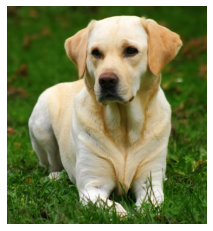

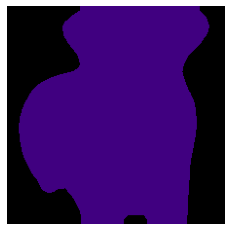

In [10]:
dlab = torchvision.models.segmentation.deeplabv3_resnet101(pretrained=1).eval()

segment(dlab, './images/labrador.jpg')
#torchvision.utils.draw_segmentation_masks('./images/labrador.jpg', )